---
# Setup

This is a GPU free notebook!

In [1]:
# Imports
import pathlib

import torch
import numpy as np
import matplotlib.pyplot as plt

import torch.nn as nn
import torch.optim as optim

from torchvision.utils import make_grid
import torchvision.transforms as transforms
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader, TensorDataset

from tqdm.auto import tqdm
from IPython.display import display

In [2]:
# @title Figure Settings
import logging
logging.getLogger('matplotlib.font_manager').disabled = True

import ipywidgets as widgets  # Interactive display
%config InlineBackend.figure_format = 'retina'
plt.style.use("https://raw.githubusercontent.com/NeuromatchAcademy/content-creation/main/nma.mplstyle")
my_layout = widgets.Layout()

In [3]:
# @title Helper functions (MLP Tutorial 1 Codes)

# @markdown `Net(nn.Module)`

class Net(nn.Module):
  """
  Simulate MLP Network
  """

  def __init__(self, actv, input_feature_num, hidden_unit_nums, output_feature_num):
    """
    Initialize MLP Network parameters

    Args:
      actv: string
        Activation function
      input_feature_num: int
        Number of input features
      hidden_unit_nums: list
        Number of units per hidden layer. List of integers
      output_feature_num: int
        Number of output features

    Returns:
      Nothing
    """
    super(Net, self).__init__()
    self.input_feature_num = input_feature_num # Save the input size for reshapinng later
    self.mlp = nn.Sequential() # Initialize layers of MLP

    in_num = input_feature_num # Initialize the temporary input feature to each layer
    for i in range(len(hidden_unit_nums)): # Loop over layers and create each one
      out_num = hidden_unit_nums[i] # Assign the current layer hidden unit from list
      layer = nn.Linear(in_num, out_num) # Use nn.Linear to define the layer
      in_num = out_num # Assign next layer input using current layer output
      self.mlp.add_module(f"Linear_{i}", layer) # Append layer to the model with a name

      actv_layer = eval(f"nn.{actv}") # Assign activation function (eval allows us to instantiate object from string)
      self.mlp.add_module(f"Activation_{i}", actv_layer) # Append activation to the model with a name

    out_layer = nn.Linear(in_num, output_feature_num) # Create final layer
    self.mlp.add_module('Output_Linear', out_layer) # Append the final layer

  def forward(self, x):
    """
    Simulate forward pass of MLP Network

    Args:
      x: torch.tensor
        Input data

    Returns:
      logits: Instance of MLP
        Forward pass of MLP
    """
    # Reshape inputs to (batch_size, input_feature_num)
    # Just in case the input vector is not 2D, like an image!
    x = x.view(-1, self.input_feature_num)

    logits = self.mlp(x) # forward pass of MLP
    return logits


# @markdown `train_test_classification(net, criterion, optimizer, train_loader, test_loader, num_epochs=1, verbose=True, training_plot=False)`
def train_test_classification(net, criterion, optimizer, train_loader,
                              test_loader, num_epochs=1, verbose=True,
                              training_plot=False, device='cpu'):
  """
  Accumulate training loss/Evaluate performance

  Args:
    net: Instance of Net class
      Describes the model with ReLU activation, batch size 128
    criterion: torch.nn type
      Criterion combines LogSoftmax and NLLLoss in one single class.
    optimizer: torch.optim type
      Implements Adam algorithm.
    train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
    num_epochs: int
      Number of epochs [default: 1]
    verbose: boolean
      If True, print statistics
    training_plot=False
      If True, display training plot
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    Nothing
  """
  net.to(device)
  net.train()
  training_losses = []
  for epoch in tqdm(range(num_epochs)):  # Loop over the dataset multiple times
    running_loss = 0.0
    for i, data in enumerate(train_loader, 0):
      # Get the inputs; data is a list of [inputs, labels]
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      # Zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(inputs)

      loss = criterion(outputs, labels)
      loss.backward()
      optimizer.step()

      # Print statistics
      if verbose:
        training_losses += [loss.item()]

  net.eval()

  def test(data_loader):
    """
    Function to gauge network performance

    Args:
      data_loader: torch.utils.data type
        Combines the test dataset and sampler, and provides an iterable over the given dataset.

    Returns:
      acc: float
        Performance of the network
      total: int
        Number of datapoints in the dataloader
    """
    correct = 0
    total = 0
    for data in data_loader:
      inputs, labels = data
      inputs = inputs.to(device).float()
      labels = labels.to(device).long()

      outputs = net(inputs)
      _, predicted = torch.max(outputs, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    return total, acc

  train_total, train_acc = test(train_loader)
  test_total, test_acc = test(test_loader)

  if verbose:
    print(f'\nAccuracy on the {train_total} training samples: {train_acc:0.2f}')
    print(f'Accuracy on the {test_total} testing samples: {test_acc:0.2f}\n')

  if training_plot:
    plt.plot(training_losses)
    plt.xlabel('Batch')
    plt.ylabel('Training loss')
    plt.show()

  return train_acc, test_acc


# @markdown `shuffle_and_split_data(X, y, seed)`
def shuffle_and_split_data(X, y, seed):
  """
  Helper function to shuffle and split data

  Args:
    X: torch.tensor
      Input data
    y: torch.tensor
      Corresponding target variables
    seed: int
      Set seed for reproducibility

  Returns:
    X_test: torch.tensor
      Test data [20% of X]
    y_test: torch.tensor
      Labels corresponding to above mentioned test data
    X_train: torch.tensor
      Train data [80% of X]
    y_train: torch.tensor
      Labels corresponding to above mentioned train data
  """
  # Set seed for reproducibility
  torch.manual_seed(seed)
  # Number of samples
  N = X.shape[0]
  # Shuffle data
  shuffled_indices = torch.randperm(N)   # Get indices to shuffle data, could use torch.randperm
  X = X[shuffled_indices]
  y = y[shuffled_indices]

  # Split data into train/test
  test_size = int(0.2 * N)    # Assign test datset size using 20% of samples
  X_test = X[:test_size]
  y_test = y[:test_size]
  X_train = X[test_size:]
  y_train = y[test_size:]

  return X_test, y_test, X_train, y_train

In [4]:
# @title Plotting functions
def imshow(img):
  """
  Helper function to plot unnormalised image

  Args:
    img: torch.tensor
      Image to be displayed

  Returns:
    Nothing
  """
  img = img / 2 + 0.5     # Unnormalize
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1, 2, 0)))
  plt.axis(False)
  plt.show()


def sample_grid(M=500, x_max=2.0):
  """
  Helper function to simulate sample meshgrid

  Args:
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points

  Returns:
    X_all: torch.tensor
      Concatenated meshgrid tensor
  """
  ii, jj = torch.meshgrid(torch.linspace(-x_max, x_max,M),
                          torch.linspace(-x_max, x_max, M),
                          indexing='ij')
  X_all = torch.cat([ii.unsqueeze(-1),
                     jj.unsqueeze(-1)],
                     dim=-1).view(-1, 2)
  return X_all


def plot_decision_map(X_all, y_pred, X_test, y_test,
                      M=500, x_max=2.0, eps=1e-3):
  """
  Helper function to plot decision map

  Args:
    X_all: torch.tensor
      Concatenated meshgrid tensor
    y_pred: torch.tensor
      Labels predicted by the network
    X_test: torch.tensor
      Test data
    y_test: torch.tensor
      Labels of the test data
    M: int
      Size of the constructed tensor with meshgrid
    x_max: float
      Defines range for the set of points
    eps: float
      Decision threshold

  Returns:
    Nothing
  """
  decision_map = torch.argmax(y_pred, dim=1)

  for i in range(len(X_test)):
    indeces = (X_all[:, 0] - X_test[i, 0])**2 + (X_all[:, 1] - X_test[i, 1])**2 < eps
    decision_map[indeces] = (K + y_test[i]).long()

  decision_map = decision_map.view(M, M).cpu()
  plt.imshow(decision_map, extent=[-x_max, x_max, -x_max, x_max], cmap='jet')
  plt.axis('off')
  plt.plot()

In [5]:
# @title Set random seed

# @markdown Executing `set_seed(seed=seed)` you are setting the seed

# For DL its critical to set the random seed so that students can have a
# baseline to compare their results to expected results.
# Read more here: https://pytorch.org/docs/stable/notes/randomness.html

# Call `set_seed` function in the exercises to ensure reproducibility.
import random
import torch

def set_seed(seed=None, seed_torch=True):
  """
  Function that controls randomness. NumPy and random modules must be imported.

  Args:
    seed : Integer
      A non-negative integer that defines the random state. Default is `None`.
    seed_torch : Boolean
      If `True` sets the random seed for pytorch tensors, so pytorch module
      must be imported. Default is `True`.

  Returns:
    Nothing.
  """
  if seed is None:
    seed = np.random.choice(2 ** 32)
  random.seed(seed)
  np.random.seed(seed)
  if seed_torch:
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.benchmark = False
    torch.backends.cudnn.deterministic = True

  print(f'Random seed {seed} has been set.')


# In case that `DataLoader` is used
def seed_worker(worker_id):
  """
  DataLoader will reseed workers following randomness in
  multi-process data loading algorithm.

  Args:
    worker_id: integer
      ID of subprocess to seed. 0 means that
      the data will be loaded in the main process
      Refer: https://pytorch.org/docs/stable/data.html#data-loading-randomness for more details

  Returns:
    Nothing
  """
  worker_seed = torch.initial_seed() % 2**32
  np.random.seed(worker_seed)
  random.seed(worker_seed)

In [6]:
# @title Set device (GPU or CPU). Execute `set_device()`
# especially if torch modules used.

# Inform the user if the notebook uses GPU or CPU.

def set_device():
  """
  Set the device. CUDA if available, CPU otherwise

  Args:
    None

  Returns:
    Nothing
  """
  device = "cuda" if torch.cuda.is_available() else "cpu"
  if device != "cuda":
    print("GPU is not enabled in this notebook. \n"
          "If you want to enable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `GPU` from the dropdown menu")
  else:
    print("GPU is enabled in this notebook. \n"
          "If you want to disable it, in the menu under `Runtime` -> \n"
          "`Hardware accelerator.` and select `None` from the dropdown menu")

  return device

In [7]:
SEED = 2021
set_seed(seed=SEED)
DEVICE = set_device()

Random seed 2021 has been set.
GPU is not enabled in this notebook. 
If you want to enable it, in the menu under `Runtime` -> 
`Hardware accelerator.` and select `GPU` from the dropdown menu


In [8]:
# @title Download of the Animal Faces dataset
# @markdown Animal faces consists of 16,130 32x32 images belonging to 3 classes
import requests, os
from zipfile import ZipFile

print("Start downloading and unzipping `AnimalFaces` dataset...")
name = 'AnimalFaces32x32'
fname = f"{name}.zip"
url = f"https://osf.io/kgfvj/download"
r = requests.get(url, allow_redirects=True)
with open(fname, 'wb') as fh:
  fh.write(r.content)

with ZipFile(fname, 'r') as zfile:
  zfile.extractall(f"./{name}")

if os.path.exists(fname):
  os.remove(fname)
else:
  print(f"The file {fname} does not exist")

os.chdir(name)
print("Download completed.")

Start downloading and unzipping `AnimalFaces` dataset...
Download completed.


In [9]:
# @title Data Loader
# @markdown Execute this cell!
K = 4
sigma = 0.4
N = 1000

t=torch.linspace(0,1,N)
X=torch.zeros(K*N,2)
y=torch.zeros(K*N)

for k in range(K):

  X[k*N:(k+1)*N, 0] = t*(torch.sin(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  X[k*N:(k+1)*N, 1] = t*(torch.cos(2*np.pi/K*(2*t+k)) + sigma**2*torch.randn(N))   # [TO-DO]
  y[k*N:(k+1)*N] = k

X_test,y_test,X_train,y_train=shuffle_and_split_data(X,y, seed=SEED)

batch_size=128

g_seed=torch.Generator()
g_seed.manual_seed(SEED)

test_data=TensorDataset(X_test,y_test)

test_loader=DataLoader(test_data,batch_size=batch_size,shuffle=False,num_workers=0,worker_init_fn=seed_worker,generator=g_seed)

train_data=TensorDataset(X_train,y_train)

train_loader = DataLoader(train_data,
                          batch_size=batch_size,
                          drop_last=True,
                          shuffle=True,
                          worker_init_fn=seed_worker,
                          generator=g_seed,
                          )




---
# Section 1: Wider vs deeper networks

*Time estimate: ~45 mins*

## Coding Exercise 1: Wide vs. Deep while keeping number of parameters same
Let's find the optimal number of hidden layers under a fixed number of parameters constraint!
But first, we need a model parameter counter. You could iterate over the model layers by calling `.parameters()` and then use `.numel()` to count the layer parameters. Also, you can use [`requires_grad`](https://pytorch.org/docs/stable/notes/autograd.html) attribute to make sure it's a trainable parameter. E.g.,
```python
x = torch.ones(10, 5, requires_grad=True)
```
After defining the counter function, we will step by step increase the depth and then iterate over the possible number of hidden units (assuming same for all hidden layers); then using our parameter counter choose the number of hidden units that results in overall close to `max_par_count` parameters.

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 81.59
Accuracy on the 800 testing samples: 81.50



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 85.03
Accuracy on the 800 testing samples: 85.88



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 90.06
Accuracy on the 800 testing samples: 89.88



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 85.25
Accuracy on the 800 testing samples: 86.62



  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 86.22
Accuracy on the 800 testing samples: 86.25



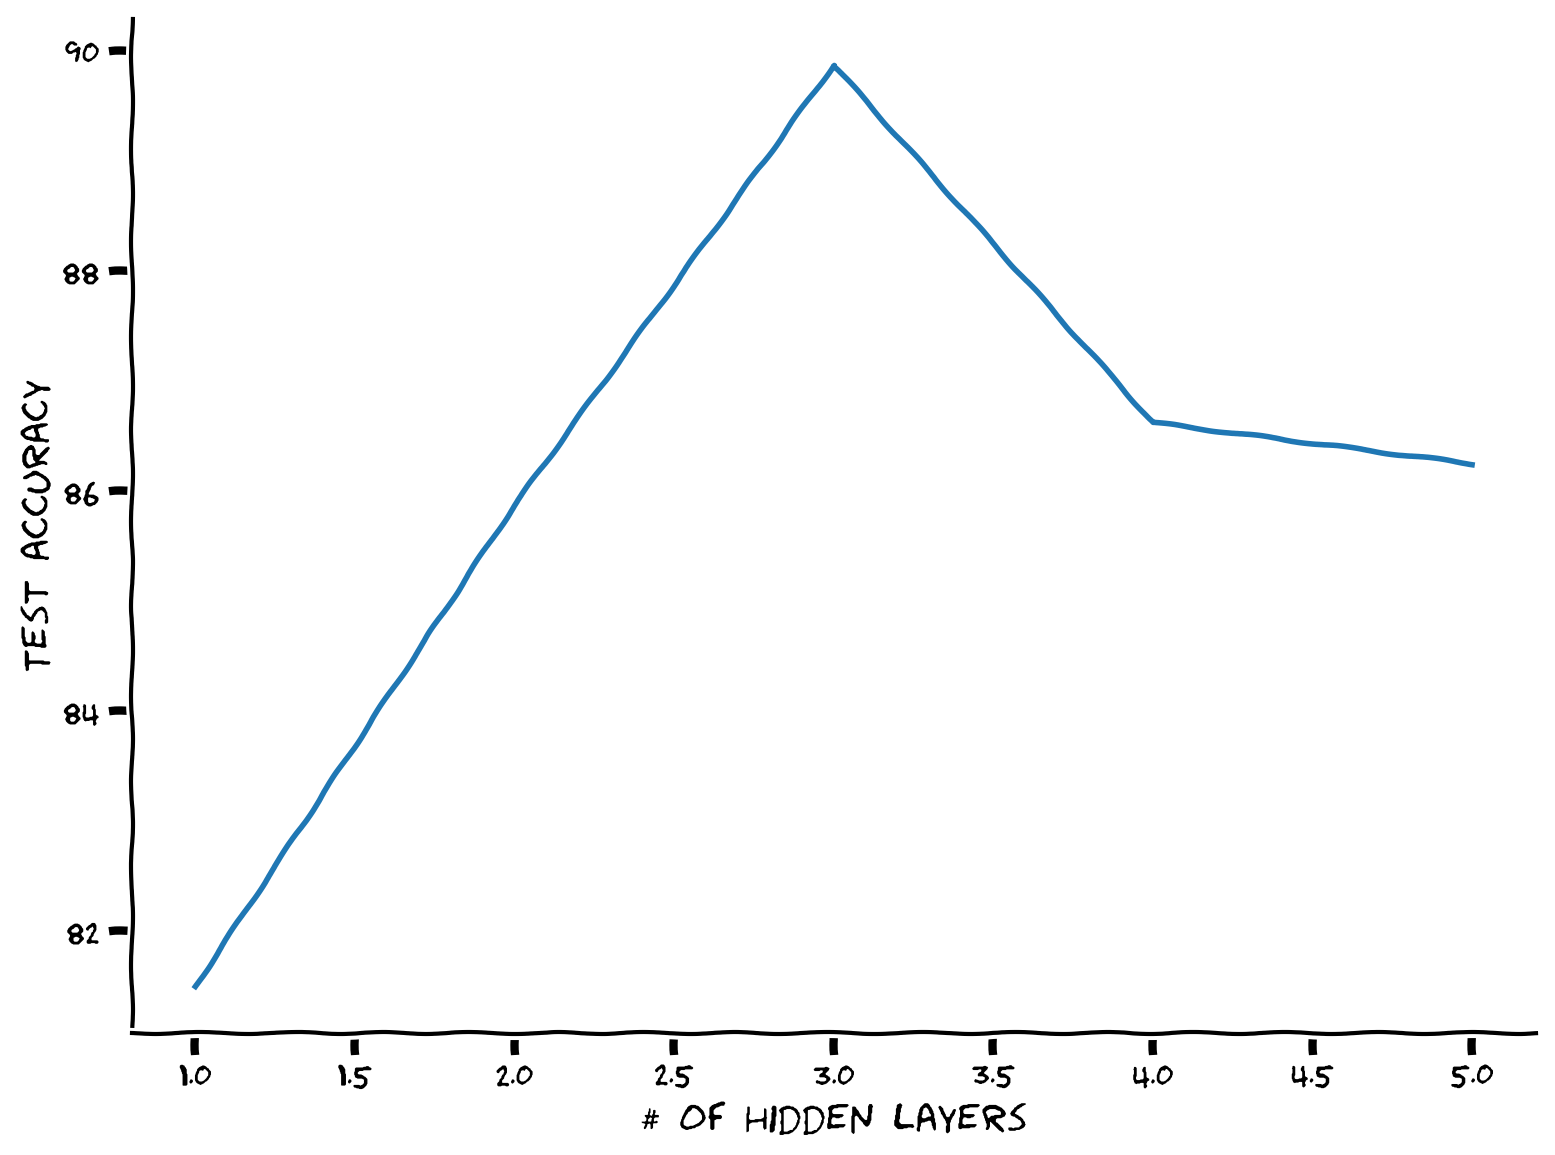

In [10]:
def run_depth_optimizer(max_par_count, max_hidden_layer, device):
  """
  Simulate Depth Optimizer

  Args:
    max_par_count: int
      Maximum number of hidden units in layer of depth optimizer
    max_hidden_layer: int
      Maximum number of hidden layers within depth optimizer
    device: string
      CUDA/GPU if available, CPU otherwise

  Returns:
    hidden_layers: int
      Number of hidden layers in depth optimizer
    test_scores: list
      Log of test scores
  """

  def count_parameters(model):
    """
    Function to count model parameters

    Args:
      model: instance of Net class
        MLP instance

    Returns:
      par_count: int
        Number of parameters in network
    """

    par_count=0

    for p in model.parameters():

       if p.requires_grad:

        par_count +=p.numel()

    return par_count

  hidden_layers = range(1, max_hidden_layer+1)

  # Test test score list
  test_scores = []

  for hidden_layer in hidden_layers:

    hidden_units=np.ones(hidden_layer,dtype=int)

    wide_net=Net('ReLU()',X_train.shape[1],hidden_units,K).to(device)

    par_count=count_parameters(wide_net)

    while par_count < max_par_count:

      hidden_units +=1

      wide_net = Net('ReLU()', X_train.shape[1], hidden_units, K).to(device)
      par_count = count_parameters(wide_net)


    # Train it
    criterion=nn.CrossEntropyLoss()
    optimizer=optim.Adam(wide_net.parameters(),lr=1e-3)
    _,test_acc=train_test_classification(wide_net,criterion,optimizer,train_loader,test_loader,num_epochs=100,device=device)
    test_scores +=[test_acc]

  return hidden_layers,test_scores


set_seed(seed=SEED)
max_par_count = 100
max_hidden_layer = 5
## Uncomment below to test your function
hidden_layers, test_scores = run_depth_optimizer(max_par_count, max_hidden_layer, DEVICE)
with plt.xkcd():
  plt.xlabel('# of hidden layers')
  plt.ylabel('Test accuracy')
  plt.plot(hidden_layers, test_scores)
  plt.show()


## Think! 1: Why the tradeoff?
Here we see that there is a particular number of hidden layers that is optimum. Why do you think increasing hidden layers after a certain point hurt in this scenario?

Because the learnability becomes an issue i.e., specifically the vanishing gradients is a problem.

## Section 1.1: Where Wide Fails
Let's use the same spiral dataset generated before with two features. And then add more polynomial features (which makes the first layer wider). And finally, train a single linear layer. We could use the same MLP network with no hidden layers (though it would not be called an MLP anymore!).

Note that we will add polynomial terms upto $P=50$ which means that for every $x_1^n x_2^m$ term, $n+m\leq P$. Now it's fun math exercise to prove why the total number of polynomial features upto $P$ becomes:

\begin{equation}
\text{# of terms} = \frac{(P+1)(P+2)}{2}
\end{equation}

Also, we don't need the polynomial term with degree zero (which is the constatnt term) since `nn.Linear` layers have bias terms. Therefore we will have one fewer polynomial feature.

Random seed 2021 has been set.


  0%|          | 0/100 [00:00<?, ?it/s]


Accuracy on the 3200 training samples: 69.88
Accuracy on the 800 testing samples: 72.62



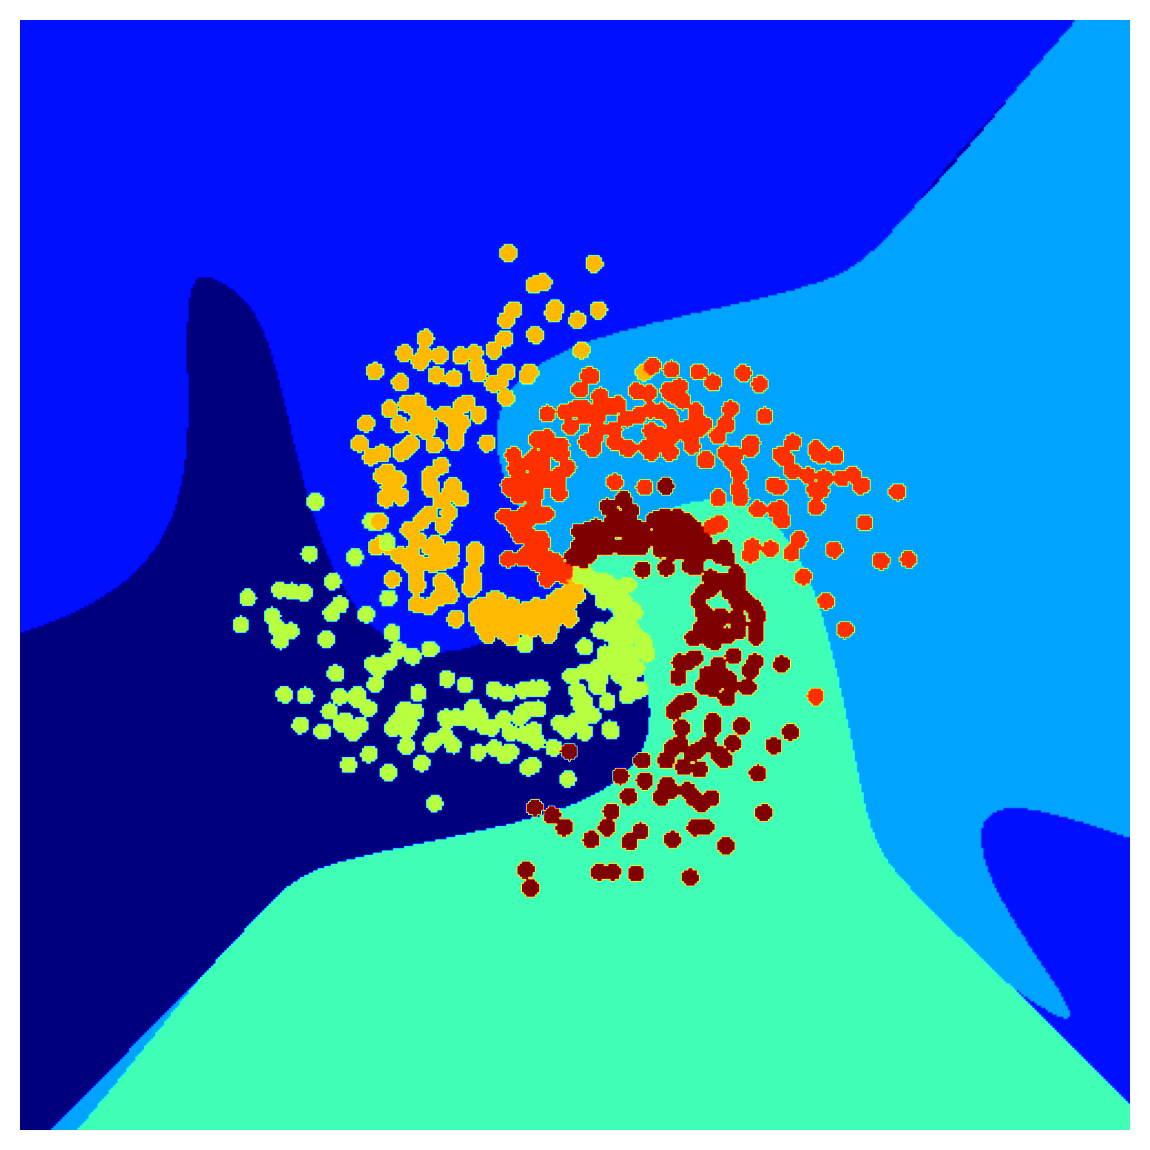

Number of features: 1325


In [11]:
def run_poly_classification(poly_degree, device='cpu', seed=0):
  """
  Helper function to run the above defined polynomial classifier

  Args:
    poly_degree: int
      Degree of the polynomial
    device: string
      CUDA/GPU if available, CPU otherwise
    seed: int
      A non-negative integer that defines the random state. Default is 0.

  Returns:
    num_features: int
      Number of features
  """

  def make_poly_features(poly_degree, X):
    """
    Function to define the number of polynomial features except the bias term

    Args:
      poly_degree: int
        Degree of the polynomial
      X: torch.tensor
        Input data

    Returns:
      num_features: int
        Number of features
      poly_X: torch.tensor
        Polynomial term
    """

    num_features=(poly_degree+1)*(poly_degree+2) //2-1
    poly_X=torch.zeros((X.shape[0],num_features))
    count=0
    for i in range(poly_degree+1):

      for j in range(poly_degree+1):

        if  j+i >0:

          if j+i <=poly_degree:

            poly_X[:, count] = X[:, 0]**i * X [:, 1]**j

            count +=1

    return poly_X,num_features

  poly_X_test,num_features=make_poly_features(poly_degree,X_test)
  poly_X_train, _ = make_poly_features(poly_degree, X_train)

  batch_size = 128

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  poly_test_data = TensorDataset(poly_X_test, y_test)
  poly_test_loader = DataLoader(poly_test_data,
                                batch_size=batch_size,
                                shuffle=False,
                                num_workers=1,
                                worker_init_fn=seed_worker,
                                generator=g_seed)

  poly_train_data = TensorDataset(poly_X_train, y_train)
  poly_train_loader = DataLoader(poly_train_data,
                                 batch_size=batch_size,
                                 shuffle=True,
                                 num_workers=1,
                                 worker_init_fn=seed_worker,
                                 generator=g_seed)

  # Define a linear model using MLP class
  poly_net = Net('ReLU()', num_features, [], K).to(device)

  # Train it!
  criterion = nn.CrossEntropyLoss()
  optimizer = optim.Adam(poly_net.parameters(), lr=1e-3)
  _, _ = train_test_classification(poly_net, criterion, optimizer,
                                   poly_train_loader, poly_test_loader,
                                   num_epochs=100, device=DEVICE)
  # Test it
  X_all = sample_grid().to(device)
  poly_X_all, _ = make_poly_features(poly_degree, X_all)
  y_pred = poly_net(poly_X_all.to(device))

  # Plot it
  plot_decision_map(X_all.cpu(), y_pred.cpu(), X_test.cpu(), y_test.cpu())
  plt.show()

  return num_features


set_seed(seed=SEED)
max_poly_degree = 50
num_features = run_poly_classification(max_poly_degree, DEVICE, SEED)
print(f'Number of features: {num_features}')


### Think! 1.1: Does a wide model generalize well?

Do you think this model is performing well outside its training distribution? Why?

Absolutely not! It even started to form unconnected clusters outside of training distribution.

---
# Section 2: Deeper MLPs

*Time estimate: ~55 mins*

## Coding Exercise 2: Dataloader on a real-world dataset
Let's build our first real-world dataset loader with Data Preprocessing and Augmentation! And we will use the Torchvision transforms to do it.
We'd like to have a simple data augmentation with the following steps:
* Random rotation with $10$ degrees (`.RandomRotation`)
* Random horizontal flipping (`.RandomHorizontalFlip`)
and we'd like a preprocessing that:
* makes Pytorch tensors in the range $[0, 1]$ (`.ToTensor`)
* normalizes the input in the range $[-1, 1]$ (.`Normalize`)
<br>

**Hint:** For more info on transform, see the [official documentation](https://pytorch.org/vision/stable/transforms.html).

Random seed 2021 has been set.


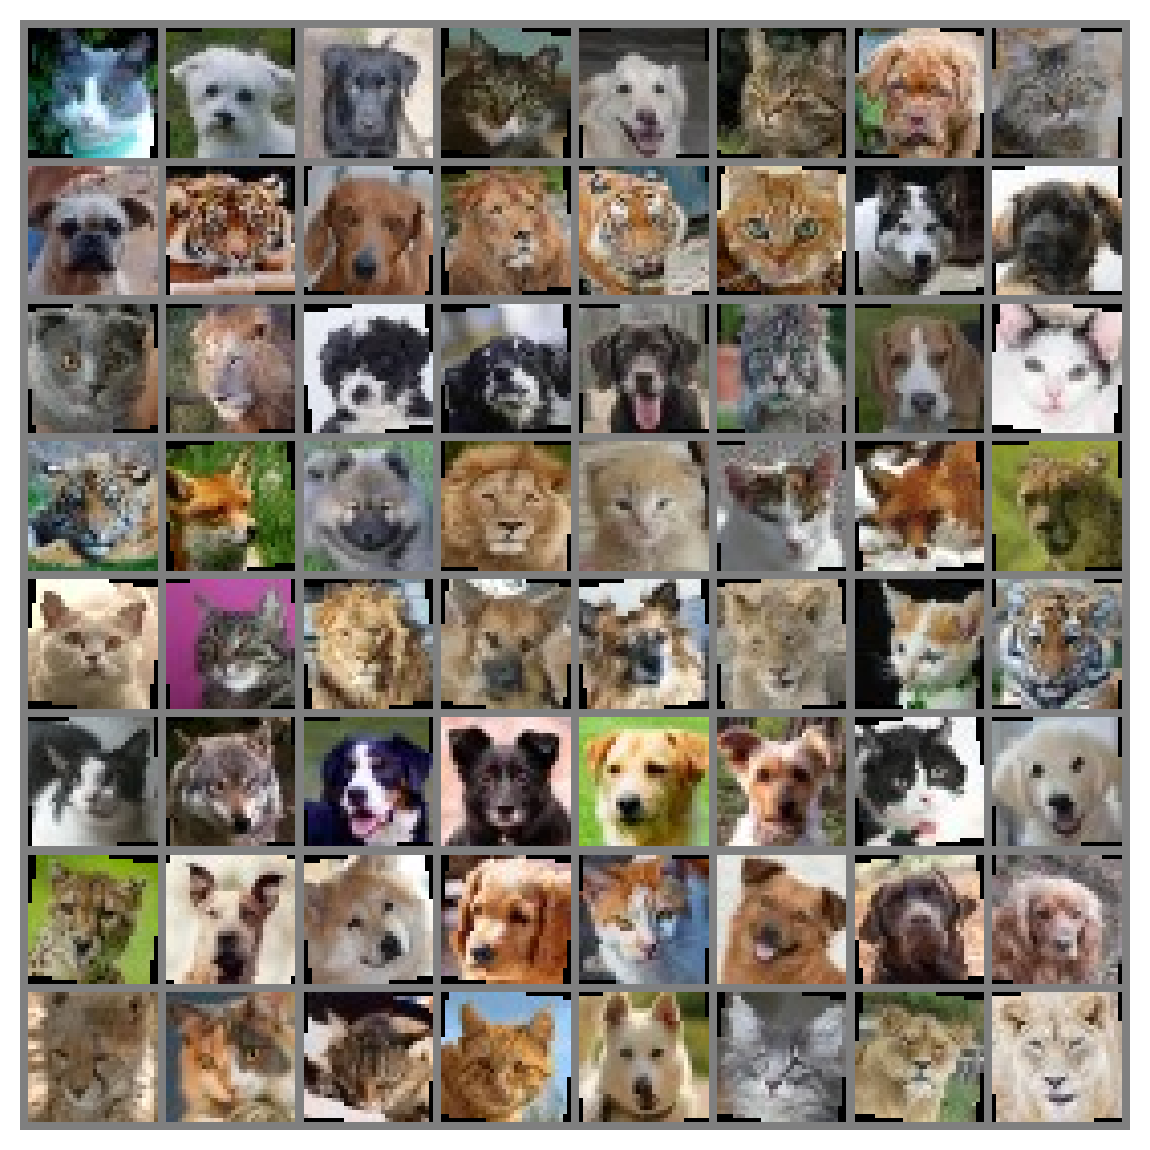

In [13]:
def get_data_loaders(batch_size, seed):
  """
  Helper function to get data loaders

  Args:
    batch_size: int
      Batch size
    seed: int
      A non-negative integer that defines the random state.

  Returns:
    img_train_loader: torch.utils.data type
      Combines the train dataset and sampler, and provides an iterable over the given dataset.
    img_test_loader: torch.utils.data type
      Combines the test dataset and sampler, and provides an iterable over the given dataset.
  """

  augmentation_transforms=[transforms.RandomRotation(10),transforms.RandomHorizontalFlip()]

  mean = (0.5, 0.5, 0.5) # defined sequence of means per channel
  std = (0.5, 0.5, 0.5) # defined sequence of std deviations per channel
  # Note that the transform should normalize each channel: output[channel] = (input[channel] - mean[channel]) / std[channel]

  preprocessing_transforms=[transforms.ToTensor(),transforms.Normalize(mean,std)]

  train_transform=transforms.Compose(augmentation_transforms+preprocessing_transforms)

  test_transform=transforms.Compose(preprocessing_transforms)

  data_path=pathlib.Path('.')/'afhq'

  img_train_dataset=ImageFolder(data_path/'train',transform=train_transform)

  img_test_dataset = ImageFolder(data_path/'val', transform=test_transform)

  g_seed = torch.Generator()
  g_seed.manual_seed(seed)
  # Define the dataloader objects (they can load batch by batch)

  img_train_loader=DataLoader(img_train_dataset,batch_size=batch_size,shuffle=True , worker_init_fn=seed_worker,
                                generator=g_seed)

  img_test_loader = DataLoader(img_test_dataset,
                               batch_size=batch_size,
                               shuffle=False,
                               num_workers=1,
                               worker_init_fn=seed_worker,
                               generator=g_seed)

  return img_train_loader, img_test_loader


batch_size = 64
set_seed(seed=SEED)
## Uncomment below to test your function
img_train_loader, img_test_loader = get_data_loaders(batch_size, SEED)
## get some random training images
dataiter = iter(img_train_loader)
images, labels = next(dataiter)
## show images
imshow(make_grid(images, nrow=8))

In [16]:
# Train it
set_seed(seed=SEED)

net=Net('ReLU()',3*32*32,[64,64,64],3).to(DEVICE)

criterion=nn.CrossEntropyLoss()

optimizer=optim.Adam(net.parameters(),lr=3e-4)

_,_=train_test_classification(net,criterion,optimizer,img_train_loader,img_test_loader,num_epochs=30,device=DEVICE)

Random seed 2021 has been set.


  0%|          | 0/30 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 93.81
Accuracy on the 1500 testing samples: 89.80



In [22]:
# Visualize the feature map
# fc1_weights = net.mlp[0].weight.view(64, 3, 32, 32).detach().cpu()
# fc1_weights /= torch.max(torch.abs(fc1_weights))
# imshow(make_grid(fc1_weights, nrow=8))

## Think! 2: Why first layer features are high level?
Even though it's three layers deep, we see distinct animal faces in the first layer feature map. Do you think this MLP has a hierarchical feature representation? Why?

No, we don't see low-level features in the first layer (like edges or face parts).
This is because the MLP model does not have a preference (bias or prior)
for hierarchical feature maps; hence it won't learn it by default.

---
# Section 3: Ethical aspects

*Time estimate: ~20 mins*

---
# Summary

In the second tutorial of this day, we have dived deeper into MLPs and seen more of their mathematical and practical aspects. More specifically, we have learned about different architectures, i.e., deep, wide, and how they are dependent on the transfer function used. Also, we have learned about the importance of initialization, and we mathematically analyzed two methods for smart initialization.

---
# Bonus: The need for good initialization
In this section, we derive principles for initializing deep networks. We will see that if the weights are too large, then the forward propagation of signals will be chaotic, and the backpropagation of error gradients will explode. On the other hand, if the weights are too small, the forward propagation of signals will be ordered, and the backpropagation of error gradients will vanish. The key idea behind initialization is to choose the weights to be just right, i.e., at the edge between order and chaos. In this section, we derive this edge and show how to compute the correct initial variance of the weights.

Many of the typical initialization schemes in existing deep learning frameworks implicitly employ this principle of initialization at the edge of chaos. So this section can be safely skipped on first pass and **is, hence, a bonus section**.

## Xavier initialization
Let us look at the scale distribution of an output (e.g., a hidden variable)  $o_i$ for some fully-connected layer without nonlinearities. With $n_{in}$  inputs ($x_j$)  and their associated weights $w_{ij}$  for this layer. Then an output is given by,

\begin{equation}
  o_{i} = \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j
\end{equation}

The weights $w_{ij}$  are all drawn independently from the same distribution. Furthermore, let us assume that this distribution has zero mean and variance  $\sigma^2$. Note that this does not mean that the distribution has to be Gaussian, just that the mean and variance need to exist. For now, let us assume that the inputs to the layer  $x_j$ also have zero mean and variance  $\gamma^2$  and that they are independent of $w_{ij}$ and independent of each other. In this case, we can compute the mean and variance of $o_i$ as follows:


\begin{align}
  E[o_i] &= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij} x_j] \\ \\
  &= \sum_{j=1}^{n_\mathrm{in}} E[w_{ij}] E[x_j] = 0, \\ \\ \\
  \mathrm{Var}[o_i] &= E[o_i^2] - (E[o_i])^2 \\ \\
  &= \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij} x^2_j] - 0 \\ \\
  &= \sum_{j=1}^{n_\mathrm{in}} E[w^2_{ij}] E[x^2_j] \\ \\
  &= n_\mathrm{in} \sigma^2 \gamma^2
\end{align}

<br>

One way to keep the variance fixed is to set $n_{in}\sigma^2=1$ . Now consider backpropagation. There we face a similar problem, albeit with gradients being propagated from the layers closer to the output. Using the same reasoning as for forward propagation, we see that the gradients’ variance can blow up unless $n_{out}\sigma^2=1$ , where  $n_{out}$ is the number of outputs of this layer. This leaves us in a dilemma: we cannot possibly satisfy both conditions simultaneously. Instead, we simply try to satisfy:

\begin{align}
\frac{1}{2} (n_\mathrm{in} + n_\mathrm{out}) \sigma^2 = 1 \text{ or equivalently }
\sigma = \sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}
\end{align}

<br>

This is the reasoning underlying the now-standard and practically beneficial Xavier initialization, named after the first author of its creators [Glorot and Bengio, 2010](https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf). Typically, the Xavier initialization samples weights from a Gaussian distribution with zero mean and variance  $\sigma^2=\frac{2}{(n_{in}+n_{out})}$,


\begin{equation}
  w_{ij} \sim \mathcal{N} \left (\mu=0, \sigma=\sqrt{\frac{2}{(n_{in}+n_{out})}} \right)
\end{equation}


We can also adapt Xavier’s intuition to choose the variance when sampling weights from a uniform distribution. Note that the uniform distribution $\mathcal{U}(−a,a)$ has variance $\frac{a^2}{3}$. Plugging this into our condition on $\sigma^2$ yields the suggestion to initialize according to


\begin{equation}
w_{ij} \sim  \mathcal{U} \left(-\sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}, \sqrt{\frac{6}{n_\mathrm{in} + n_\mathrm{out}}}\right)
\end{equation}


This explanation is mainly taken from [here](https://d2l.ai/chapter_multilayer-perceptrons/numerical-stability-and-init.html).

## Initialization with transfer function
Let's derive the optimal gain for LeakyReLU following similar steps.

LeakyReLU is described mathematically:

\begin{equation}
f(x)=\left\{
  \begin{array}{ll}
    \alpha \cdot x & \text { for } x<0 \\
    x & \text { for } x \geq 0
  \end{array}\right.
\end{equation}

where $\alpha$ controls the angle of the negative slope.

Considering a single layer with this activation function gives,

\begin{align}
o_{i} &= \sum_{j=1}^{n_\mathrm{in}} w_{ij} x_j\\
z_{i} &= f\left( o_{i} \right)
\end{align}

where $z_i$ denotes the activation of node $i$.

The expectation of the output is still zero, i.e., $\mathbb{E}[f(o_i)=0]$, but the variance changes, and assuming that the probability $P(x < 0) = 0.5$, we have that:


\begin{align}
\mathrm{Var}[f(o_i)] &= \mathbb{E}[f(o_i)^2] - \left( \mathbb{E}[f(o_i)] \right)^{2} \\ \\
&= \frac{\mathrm{Var}[o_i] + \alpha^2 \mathrm{Var}[o_i]}{2} \\ \\
&= \frac{1+\alpha^2}{2}n_\mathrm{in} \sigma^2 \gamma^2
\end{align}

where $\gamma$ is the variance of the distribution of the inputs $x_j$ and $\sigma$ is the variance of the distribution of weights $w_{ij}$, as before.

Therefore, following the rest of derivation as before,

<br>

\begin{equation}
\sigma = gain\sqrt{\frac{2}{n_\mathrm{in} + n_\mathrm{out}}}, \, \text{where} \,\, gain = \sqrt{\frac{2}{1+\alpha^2}}
\end{equation}

As we can see from the derived formula of $\sigma$, the transfer function we choose is related with the variance of the distribution of the weights. As the negative slope of the LeakyReLU $\alpha$ becomes larger, the $gain$ becomes smaller and thus, the distribution of the weights is narrower. On the other hand, as $\alpha$ becomes smaller and smaller, the distribution of the weights is wider. Recall that, we initialize our weights, for example, by sampling from a normal distribution with zero mean and variance $\sigma^2$.

## Best gain for Xavier Initialization with Leaky ReLU
You're probably running out of time, so let me explain what's happening here. We derived a theoretical gain for initialization. But the question is whether it holds in practice? Here we have a setup to confirm our finding. We will try a range of gains and see the empirical optimum and whether it matches our theoretical value!

If you have time left, you can change the distribution to sample the initial weights from a uniform distribution by changing the `mode` argument.

In [18]:
N = 10  # Number of trials
gains = np.linspace(1/N, 3.0, N)
test_accs = []
train_accs = []
mode = 'uniform'
for gain in gains:
  print(f'\ngain: {gain:.2f}')

  def init_weights(m, mode='normal'):
    if type(m) == nn.Linear:
      if mode == 'normal':
        torch.nn.init.xavier_normal_(m.weight, gain)
      elif mode == 'uniform':
        torch.nn.init.xavier_uniform_(m.weight, gain)
      else:
        print("No specific mode selected. Please choose `normal` or `uniform`")

  negative_slope = 0.1
  actv = f'LeakyReLU({negative_slope})'
  set_seed(seed=SEED)
  net = Net(actv, 3*32*32, [128, 64, 32], 3).to(DEVICE)
  net.apply(init_weights)
  criterion = nn.CrossEntropyLoss()

  optimizer = optim.SGD(net.parameters(), lr=1e-2)
  train_acc, test_acc = train_test_classification(net, criterion, optimizer,
                                                  img_train_loader,
                                                  img_test_loader,
                                                  num_epochs=1,
                                                  verbose=True,
                                                  device=DEVICE)
  test_accs += [test_acc]
  train_accs += [train_acc]


gain: 0.10
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 32.39
Accuracy on the 1500 testing samples: 33.33


gain: 0.42
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 46.33
Accuracy on the 1500 testing samples: 46.93


gain: 0.74
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 63.92
Accuracy on the 1500 testing samples: 62.40


gain: 1.07
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 69.63
Accuracy on the 1500 testing samples: 66.93


gain: 1.39
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 70.92
Accuracy on the 1500 testing samples: 68.67


gain: 1.71
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 71.47
Accuracy on the 1500 testing samples: 67.93


gain: 2.03
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 68.79
Accuracy on the 1500 testing samples: 67.73


gain: 2.36
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 68.15
Accuracy on the 1500 testing samples: 66.20


gain: 2.68
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 67.33
Accuracy on the 1500 testing samples: 67.73


gain: 3.00
Random seed 2021 has been set.


  0%|          | 0/1 [00:00<?, ?it/s]


Accuracy on the 14630 training samples: 66.75
Accuracy on the 1500 testing samples: 66.13



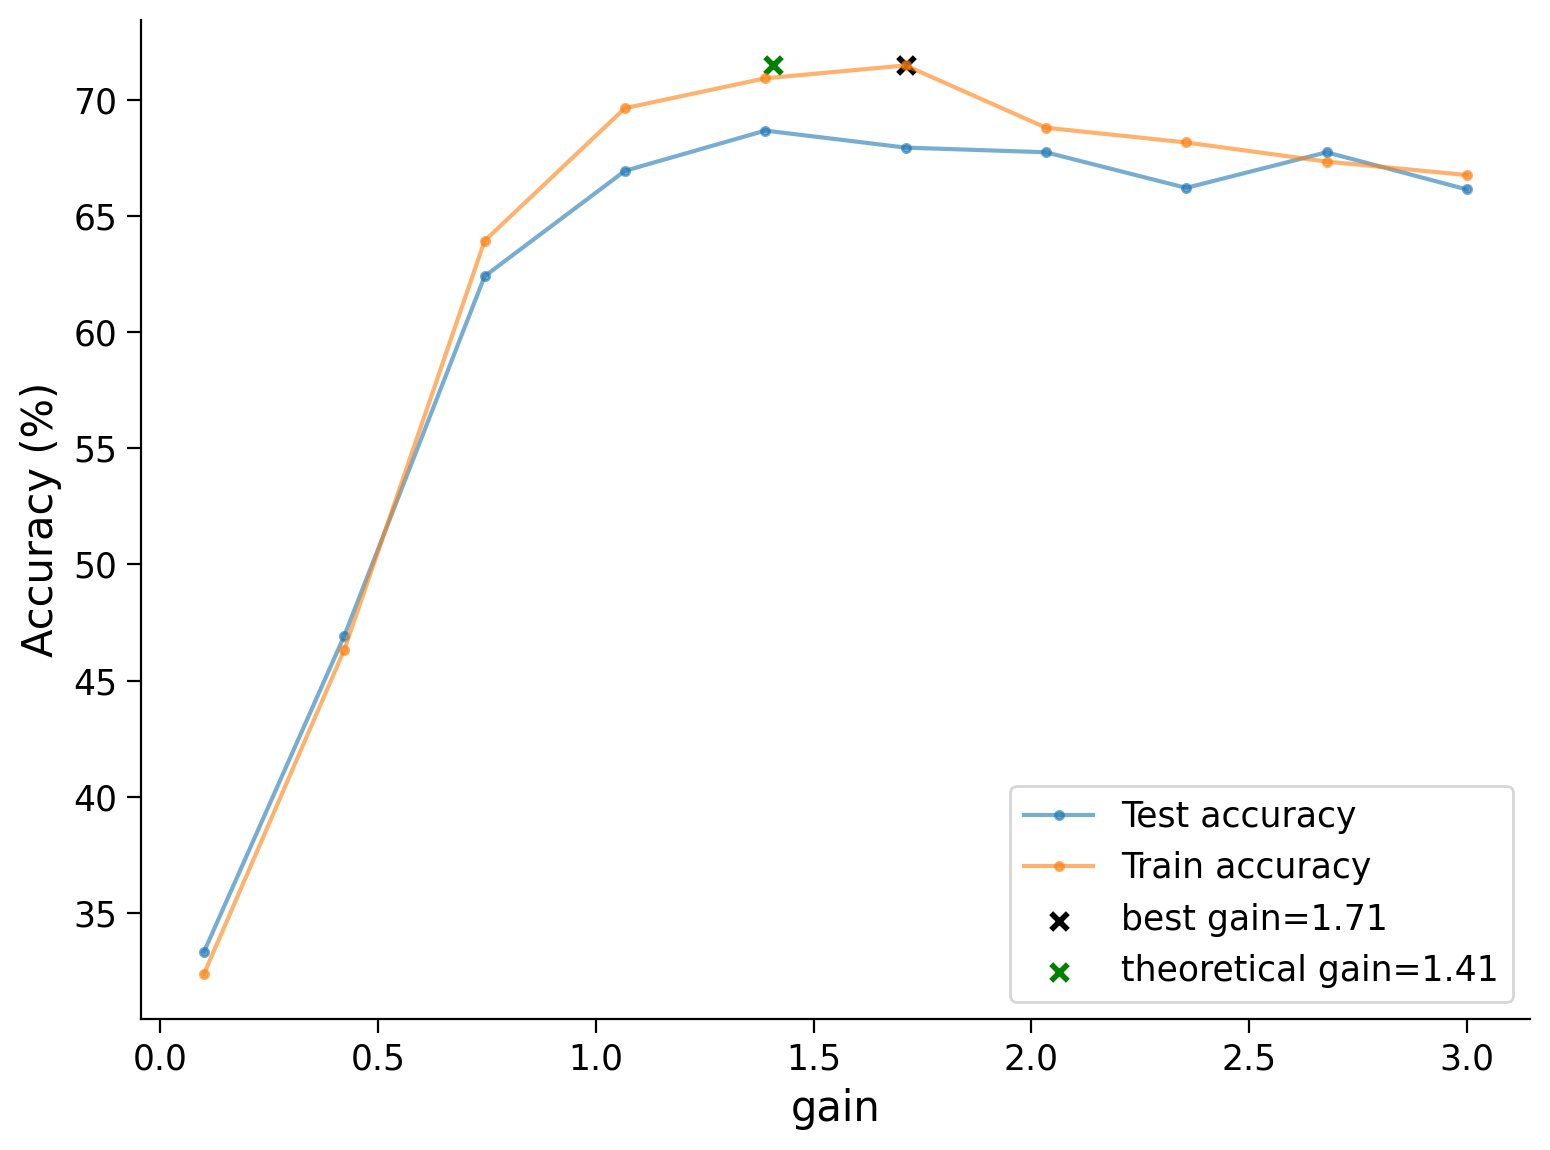

In [23]:
# Find the gain that leads to the highest accuracy
best_gain = gains[np.argmax(train_accs)]

# Calculate the theoretical gain
theoretical_gain = np.sqrt(2.0 / (1 + negative_slope ** 2))

plt.figure()
plt.plot(gains, test_accs, label='Test accuracy', marker='.', alpha=0.6)
plt.plot(gains, train_accs, label='Train accuracy', marker='.', alpha=0.6)
plt.scatter(best_gain, max(train_accs),
            label=f'best gain={best_gain:.2f}',
            c='k', marker ='x', linewidths=2)
plt.scatter(theoretical_gain, max(train_accs),
            label=f'theoretical gain={theoretical_gain:.2f}',
            c='g', marker ='x', linewidths=2)
plt.ylabel('Accuracy (%)')
plt.xlabel('gain')
plt.legend()
plt.show()